## IWT–SVD Minimal Reproduction (Config)

- Method: 2-level Integer Wavelet Transform (5/3 lifting) + SVD watermark embedding in HH₂ (quadrant-SVD).
- Parameters: alpha = 0.01, k = 32
- Cover: 512×512 grayscale (uint8)
- Watermark: 256×256 grayscale (uint8), internally resized to 128×128 for HH₂ operations
- Key validation:
  - IWT(5/3) reversibility: exact reconstruction (PSNR = inf)
  - Watermark recovery: NCC at 128×128 is ~1.0
  - NCC at 256×256 matches the theoretical resize baseline (256→128→256)



In [4]:
import sys, os, platform, zipfile, shutil, random
from pathlib import Path

import numpy as np
import pandas as pd
import cv2

print("Python:", sys.version)
print("Platform:", platform.platform())
print("OpenCV:", cv2.__version__)
print("Pandas:", pd.__version__)

# Optional: skimage metrics (recommended)
try:
    from skimage.metrics import peak_signal_noise_ratio as psnr
    from skimage.metrics import structural_similarity as ssim
    SKIMAGE_OK = True
    print("skimage: OK")
except Exception as e:
    SKIMAGE_OK = False
    print("skimage: NOT FOUND (ok for now). Error:", repr(e))

def psnr_np(img1, img2, data_range=255.0):
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float("inf")
    return 20 * np.log10(data_range) - 10 * np.log10(mse)

Python: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
Platform: Windows-11-10.0.26100-SP0
OpenCV: 4.11.0
Pandas: 2.2.3
skimage: OK


In [8]:
import shutil
import random

# reproducibility
SEED = 42
random.seed(SEED)

# local dataset root 
DATASET_ROOT = Path("Human faces and object dataset")
CSV_PATH = DATASET_ROOT / "image_labels.csv"
IMG_ROOT = DATASET_ROOT / "Images"

MALE_DIR = IMG_ROOT / "male_faces"
FEMALE_DIR = IMG_ROOT / "female_faces"
OBJECT_DIR = IMG_ROOT / "Objects"

assert DATASET_ROOT.exists(), f"Dataset folder not found: {DATASET_ROOT.resolve()}"
assert CSV_PATH.exists(), f"CSV not found: {CSV_PATH.resolve()}"
assert MALE_DIR.exists() and FEMALE_DIR.exists() and OBJECT_DIR.exists(), "Image subfolders missing under Images/"

# how many we want for the minimal reproducible debug set
N_MALE = 5
N_FEMALE = 5
N_OBJECT = 5

# output sample structure
SAMPLES_DIR = Path("samples")
SAMPLES_FACES_DIR = SAMPLES_DIR / "faces"
SAMPLES_OBJECTS_DIR = SAMPLES_DIR / "objects"

# clean old samples every run (keeps things deterministic)
if SAMPLES_DIR.exists():
    shutil.rmtree(SAMPLES_DIR)
SAMPLES_FACES_DIR.mkdir(parents=True, exist_ok=True)
SAMPLES_OBJECTS_DIR.mkdir(parents=True, exist_ok=True)

# load labels (we'll keep it around for later, but sampling here is folder-based)
df = pd.read_csv(CSV_PATH)
print("CSV loaded:", CSV_PATH.name, "| rows:", len(df), "| cols:", list(df.columns))

# list image files (robust to jpg/png/jpeg…)
exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
male_files = [p for p in MALE_DIR.iterdir() if p.is_file() and p.suffix.lower() in exts]
female_files = [p for p in FEMALE_DIR.iterdir() if p.is_file() and p.suffix.lower() in exts]
object_files = [p for p in OBJECT_DIR.iterdir() if p.is_file() and p.suffix.lower() in exts]

print("Found files:", "male =", len(male_files), "| female =", len(female_files), "| object =", len(object_files))
assert len(male_files) >= N_MALE, "Not enough male images"
assert len(female_files) >= N_FEMALE, "Not enough female images"
assert len(object_files) >= N_OBJECT, "Not enough object images"

# deterministic sampling
male_pick = random.sample(male_files, N_MALE)
female_pick = random.sample(female_files, N_FEMALE)
object_pick = random.sample(object_files, N_OBJECT)

def copy_with_new_name(src_paths, out_dir, prefix):
    out_paths = []
    for i, src in enumerate(src_paths, start=1):
        dst = out_dir / f"{prefix}_{i:03d}{src.suffix.lower()}"
        shutil.copy2(src, dst)
        out_paths.append(dst)
    return out_paths

face_paths = []
face_paths += copy_with_new_name(male_pick, SAMPLES_FACES_DIR, "male")
face_paths += copy_with_new_name(female_pick, SAMPLES_FACES_DIR, "female")
obj_paths = copy_with_new_name(object_pick, SAMPLES_OBJECTS_DIR, "object")

# keep a tiny manifest for debugging/repro
manifest_rows = []
for p in face_paths:
    manifest_rows.append({"split": "faces", "sample_file": p.name, "sample_path": str(p)})
for p in obj_paths:
    manifest_rows.append({"split": "objects", "sample_file": p.name, "sample_path": str(p)})

manifest = pd.DataFrame(manifest_rows)
manifest_path = SAMPLES_DIR / "manifest.csv"
manifest.to_csv(manifest_path, index=False)

print("Wrote samples to:", SAMPLES_DIR.resolve())
print("faces:", len(face_paths), "objects:", len(obj_paths))
print("manifest:", manifest_path.resolve())


CSV loaded: image_labels.csv | rows: 5000 | cols: ['filename', 'label', 'filepath']
Found files: male = 1500 | female = 1500 | object = 2000
Wrote samples to: D:\sina_intern\jupyterProject\467\samples
faces: 10 objects: 5
manifest: D:\sina_intern\jupyterProject\467\samples\manifest.csv


In [10]:
#Cell 2 — Load sample cover + build watermark (paper-sized 512/256)

# helper: read as grayscale + resize
def load_gray_resize(path: Path, h: int, w: int):
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Failed to read image: {path}")
    img = cv2.resize(img, (w, h), interpolation=cv2.INTER_AREA)
    return img

# pick one cover to start (we'll batch later)
face_files = sorted((Path("samples") / "faces").glob("*"))
obj_files  = sorted((Path("samples") / "objects").glob("*"))

assert len(face_files) > 0, "No face samples found. Run Cell 1 first."
assert len(obj_files) > 0, "No object samples found. Run Cell 1 first."

cover_path = face_files[0]   # start with a face as cover
cover = load_gray_resize(cover_path, 512, 512)

# watermark (256x256): simple binary + text, easy to visually verify extraction
wm = np.zeros((256, 256), dtype=np.uint8)
cv2.putText(wm, "WM", (35, 160), cv2.FONT_HERSHEY_SIMPLEX, 3.6, 255, 8, cv2.LINE_AA)
wm[::16, :] = 255
wm[:, ::16] = 255

print("cover:", cover.shape, cover.dtype, "range:", int(cover.min()), int(cover.max()), "|", cover_path.name)
print("wm   :", wm.shape, wm.dtype, "range:", int(wm.min()), int(wm.max()))

# quick sanity: write previews (so you can open them outside notebook too)
out_dir = Path("samples") / "_previews"
out_dir.mkdir(parents=True, exist_ok=True)
cv2.imwrite(str(out_dir / "cover_512.png"), cover)
cv2.imwrite(str(out_dir / "wm_256.png"), wm)
print("saved previews to:", out_dir.resolve())


cover: (512, 512) uint8 range: 2 193 | female_001.jpg
wm   : (256, 256) uint8 range: 0 255
saved previews to: D:\sina_intern\jupyterProject\467\samples\_previews


In [24]:
#Cell 3 — Baseline: SVD watermark embed/extract (minimal)

def svd_embed(cover_512, wm_256, alpha=0.02):
    """
    Minimal SVD watermarking baseline:
    - embed watermark singular values into cover singular values
    - returns watermarked image and params for extraction
    """
    cover = cover_512.astype(np.float64)
    wm = cv2.resize(wm_256, (512, 512), interpolation=cv2.INTER_NEAREST).astype(np.float64)

    Uc, Sc, Vtc = np.linalg.svd(cover, full_matrices=False)
    Uw, Sw, Vtw = np.linalg.svd(wm, full_matrices=False)

    # modify singular values
    Sc_new = Sc + alpha * Sw

    # reconstruct
    watermarked = (Uc @ np.diag(Sc_new) @ Vtc)
    watermarked = np.clip(watermarked, 0, 255).astype(np.uint8)

    params = {
        "Sc": Sc,          # original singular values
        "Uw": Uw, "Vtw": Vtw,  # watermark U,V for reconstruction
        "alpha": alpha
    }
    return watermarked, params

def svd_extract(watermarked_512, params):
    """
    Extract watermark estimate from watermarked image using stored params.
    """
    y = watermarked_512.astype(np.float64)
    Uy, Sy, Vty = np.linalg.svd(y, full_matrices=False)

    Sc = params["Sc"]
    alpha = params["alpha"]
    Uw = params["Uw"]
    Vtw = params["Vtw"]

    Sw_hat = (Sy - Sc) / alpha
    wm_hat = (Uw @ np.diag(Sw_hat) @ Vtw)
    wm_hat = np.clip(wm_hat, 0, 255).astype(np.uint8)

    return wm_hat


In [26]:
#Cell 4 — Run baseline + quick metrics
alpha = 0.02
stego_svd, params_svd = svd_embed(cover, wm, alpha=alpha)
wm_hat_full = svd_extract(stego_svd, params_svd)

# bring extracted watermark back to 256x256 for comparison/visual
wm_hat = cv2.resize(wm_hat_full, (256, 256), interpolation=cv2.INTER_AREA)

print("stego_svd:", stego_svd.shape, stego_svd.dtype, stego_svd.min(), stego_svd.max())
print("wm_hat:", wm_hat.shape, wm_hat.dtype, wm_hat.min(), wm_hat.max())

# metrics
psnr_cover = psnr(cover, stego_svd, data_range=255)
ssim_cover = ssim(cover, stego_svd, data_range=255)

# NCC for watermark
def ncc(a, b):
    a = a.astype(np.float64); b = b.astype(np.float64)
    a = a - a.mean(); b = b - b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return 0.0 if denom == 0 else float((a*b).sum() / denom)

ncc_wm = ncc(wm, wm_hat)

print(f"alpha={alpha}")
print("PSNR(cover, stego_svd):", psnr_cover)
print("SSIM(cover, stego_svd):", ssim_cover)
print("NCC(wm, wm_hat):", ncc_wm)

# save previews
out_dir = Path("samples") / "_previews"
cv2.imwrite(str(out_dir / "stego_svd_512.png"), stego_svd)
cv2.imwrite(str(out_dir / "wm_hat_256.png"), wm_hat)
print("saved:", (out_dir / "stego_svd_512.png").resolve())
print("saved:", (out_dir / "wm_hat_256.png").resolve())


stego_svd: (512, 512) uint8 1 197
wm_hat: (256, 256) uint8 0 247
alpha=0.02
PSNR(cover, stego_svd): 42.32502361495092
SSIM(cover, stego_svd): 0.999130825783513
NCC(wm, wm_hat): 0.9934706935935803
saved: D:\sina_intern\jupyterProject\467\samples\_previews\stego_svd_512.png
saved: D:\sina_intern\jupyterProject\467\samples\_previews\wm_hat_256.png


In [30]:
#Cell 6 — IWT (5/3) 2D wrapper + round-trip sanity

import sys

# 1) import the repo's 1D IWT
IWT_DIR = Path("repos") / "IntegerWaveletTransform"
assert IWT_DIR.exists(), f"Missing IWT repo: {IWT_DIR.resolve()}"
sys.path.insert(0, str(IWT_DIR.resolve()))

from iwt import iwt53, iiwt53  # defined in repos/IntegerWaveletTransform/iwt.py


# 2) 2D one-level IWT using separable 1D transforms
#    forward: rows -> cols
#    inverse: cols -> rows (reverse order)
def iwt2d_53(img):
    """
    img: 2D array (H,W), integer-valued recommended.
    returns LL, LH, HL, HH (each H/2 x W/2), all integer arrays.
    """
    x = img.astype(np.int64)
    H, W = x.shape
    assert H % 2 == 0 and W % 2 == 0, "H and W must be even for this simple implementation"

    # row transform
    s_rows = np.zeros((H, W//2), dtype=np.int64)
    d_rows = np.zeros((H, W//2), dtype=np.int64)
    for r in range(H):
        s, d = iwt53(x[r, :])
        s_rows[r, :] = s
        d_rows[r, :] = d

    # col transform on s_rows and d_rows
    LL = np.zeros((H//2, W//2), dtype=np.int64)
    HL = np.zeros((H//2, W//2), dtype=np.int64)
    LH = np.zeros((H//2, W//2), dtype=np.int64)
    HH = np.zeros((H//2, W//2), dtype=np.int64)

    for c in range(W//2):
        s1, d1 = iwt53(s_rows[:, c])  # from low rows
        s2, d2 = iwt53(d_rows[:, c])  # from high rows
        LL[:, c] = s1
        HL[:, c] = d1
        LH[:, c] = s2
        HH[:, c] = d2

    return LL, LH, HL, HH


def iiwt2d_53(LL, LH, HL, HH):
    """
    inverse of iwt2d_53
    inputs are H/2 x W/2 integer arrays
    returns reconstructed image (H,W) int64
    """
    h2, w2 = LL.shape
    H, W = h2*2, w2*2

    # first invert columns to get back s_rows and d_rows
    s_rows = np.zeros((H, w2), dtype=np.int64)
    d_rows = np.zeros((H, w2), dtype=np.int64)

    for c in range(w2):
        col_s = iiwt53(LL[:, c], HL[:, c])  # reconstruct s_rows[:,c]
        col_d = iiwt53(LH[:, c], HH[:, c])  # reconstruct d_rows[:,c]
        s_rows[:, c] = col_s
        d_rows[:, c] = col_d

    # then invert rows
    x_rec = np.zeros((H, W), dtype=np.int64)
    for r in range(H):
        row = iiwt53(s_rows[r, :], d_rows[r, :])
        x_rec[r, :] = row

    return x_rec


# 3) sanity: perfect reconstruction on an integer image
x = cover.astype(np.int64)  # cover from previous cells (512x512 uint8)
LL, LH, HL, HH = iwt2d_53(x)
x_rec = iiwt2d_53(LL, LH, HL, HH)

diff = x_rec - x
print("IWT shapes:", LL.shape, LH.shape, HL.shape, HH.shape)
print("max abs diff:", int(np.max(np.abs(diff))))
print("exact equal:", bool(np.array_equal(x, x_rec)))

# convert back to uint8 for PSNR sanity (should be identical => inf)
x_rec_u8 = np.clip(x_rec, 0, 255).astype(np.uint8)

try:
    from skimage.metrics import peak_signal_noise_ratio as psnr
    print("PSNR(cover, iwt_inv(iwt(cover))):", psnr(cover, x_rec_u8, data_range=255))
except Exception:
    print("PSNR_np:", psnr_np(cover, x_rec_u8, data_range=255))


IWT shapes: (256, 256) (256, 256) (256, 256) (256, 256)
max abs diff: 0
exact equal: True
PSNR(cover, iwt_inv(iwt(cover))): inf


D:\ANACONDA\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


In [36]:
#Cell 7 — Minimal IWT-SVD (embed into HH, 1-level)

def iwt_svd_embed_minimal(cover_512_u8, wm_256_u8, alpha=0.02):
    """
    Minimal 1-level IWT-SVD watermarking:
    - 1-level IWT on cover
    - embed watermark (upsampled to HH size) into HH singular values
    - inverse IWT to reconstruct stego
    Returns: stego_u8, params
    """
    x = cover_512_u8.astype(np.int64)

    # 1) 1-level IWT
    LL, LH, HL, HH = iwt2d_53(x)  # each 256x256 int

    # 2) prepare watermark to match HH size (256x256), use int64 for SVD
    wm_hh = cv2.resize(wm_256_u8, (HH.shape[1], HH.shape[0]), interpolation=cv2.INTER_NEAREST).astype(np.float64)
    HH_f = HH.astype(np.float64)

    # 3) SVD on HH + watermark
    Uc, Sc, Vtc = np.linalg.svd(HH_f, full_matrices=False)
    Uw, Sw, Vtw = np.linalg.svd(wm_hh, full_matrices=False)

    # 4) embed in singular values (minimal baseline)
    Sc_new = Sc + alpha * Sw

    # 5) reconstruct HH'
    HH_new = Uc @ np.diag(Sc_new) @ Vtc
    HH_new = np.rint(HH_new).astype(np.int64)  # keep integer domain

    # 6) inverse IWT to stego
    x_stego = iiwt2d_53(LL, LH, HL, HH_new)
    stego_u8 = np.clip(x_stego, 0, 255).astype(np.uint8)

    params = {
        "alpha": alpha,
        "Sc": Sc,          # original HH singular values
        "Uw": Uw, "Vtw": Vtw,  # watermark basis for reconstruction
    }
    return stego_u8, params


def iwt_svd_extract_minimal(stego_512_u8, params):
    """
    Extract watermark estimate from stego image using stored params.
    Returns recovered watermark at HH size (256x256 uint8).
    """
    y = stego_512_u8.astype(np.int64)

    # 1) 1-level IWT
    LL, LH, HL, HH = iwt2d_53(y)
    HH_f = HH.astype(np.float64)

    # 2) SVD on HH'
    Uy, Sy, Vty = np.linalg.svd(HH_f, full_matrices=False)

    # 3) recover watermark singular values
    Sc = params["Sc"]
    alpha = params["alpha"]
    Uw = params["Uw"]
    Vtw = params["Vtw"]

    Sw_hat = (Sy - Sc) / alpha
    wm_hat = Uw @ np.diag(Sw_hat) @ Vtw
    wm_hat = np.clip(wm_hat, 0, 255).astype(np.uint8)

    return wm_hat


In [38]:
#Cell 8 — Run minimal IWT-SVD + metrics + save previews

alpha = 0.02
stego_iwtsvd, params_iwtsvd = iwt_svd_embed_minimal(cover, wm, alpha=alpha)

wm_hat_hh = iwt_svd_extract_minimal(stego_iwtsvd, params_iwtsvd)
wm_hat_256 = cv2.resize(wm_hat_hh, (256, 256), interpolation=cv2.INTER_AREA)

print("stego_iwtsvd:", stego_iwtsvd.shape, stego_iwtsvd.dtype, stego_iwtsvd.min(), stego_iwtsvd.max())
print("wm_hat_256  :", wm_hat_256.shape, wm_hat_256.dtype, wm_hat_256.min(), wm_hat_256.max())

psnr_cover = psnr(cover, stego_iwtsvd, data_range=255)
ssim_cover = ssim(cover, stego_iwtsvd, data_range=255)

def ncc(a, b):
    a = a.astype(np.float64); b = b.astype(np.float64)
    a = a - a.mean(); b = b - b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return 0.0 if denom == 0 else float((a*b).sum() / denom)

ncc_wm = ncc(wm, wm_hat_256)

print(f"alpha={alpha}")
print("PSNR(cover, stego_iwtsvd):", psnr_cover)
print("SSIM(cover, stego_iwtsvd):", ssim_cover)
print("NCC(wm, wm_hat):", ncc_wm)

out_dir = Path("samples") / "_previews"
cv2.imwrite(str(out_dir / "stego_iwtsvd_min_512.png"), stego_iwtsvd)
cv2.imwrite(str(out_dir / "wm_hat_iwtsvd_min_256.png"), wm_hat_256)
print("saved:", (out_dir / "stego_iwtsvd_min_512.png").resolve())
print("saved:", (out_dir / "wm_hat_iwtsvd_min_256.png").resolve())


stego_iwtsvd: (512, 512) uint8 0 194
wm_hat_256  : (256, 256) uint8 0 255
alpha=0.02
PSNR(cover, stego_iwtsvd): 48.20519346650449
SSIM(cover, stego_iwtsvd): 0.9949830655668078
NCC(wm, wm_hat): 0.9999382685117195
saved: D:\sina_intern\jupyterProject\467\samples\_previews\stego_iwtsvd_min_512.png
saved: D:\sina_intern\jupyterProject\467\samples\_previews\wm_hat_iwtsvd_min_256.png


In [40]:
#Cell 9 — 2-level IWT wrappers

def iwt2_level(img):
    # level 1
    LL1, LH1, HL1, HH1 = iwt2d_53(img)
    # level 2 on LL1
    LL2, LH2, HL2, HH2 = iwt2d_53(LL1)
    return (LL1, LH1, HL1, HH1, LL2, LH2, HL2, HH2)

def iiwt2_level(LH1, HL1, HH1, LL2, LH2, HL2, HH2):
    # inverse level 2 -> reconstruct LL1
    LL1_rec = iiwt2d_53(LL2, LH2, HL2, HH2)
    # inverse level 1 -> reconstruct full image
    x_rec = iiwt2d_53(LL1_rec, LH1, HL1, HH1)
    return x_rec


In [42]:
#Cell 10 — Corner embedding in S (singular values) on HH₂

def embed_corner(S_cover, S_wm, alpha=0.02, k=32):
    """
    Embed into the 'corners' of diagonal singular value matrix.
    With 1D S, interpret corners as head + tail indices.
    """
    S_new = S_cover.copy()
    r = min(len(S_cover), len(S_wm))
    k = min(k, r//2)

    head = np.arange(0, k)
    tail = np.arange(r-k, r)

    S_new[head] = S_cover[head] + alpha * S_wm[head]
    S_new[tail] = S_cover[tail] + alpha * S_wm[tail]
    return S_new, (head, tail)

def extract_corner(S_stego, S_cover, alpha, idxs):
    head, tail = idxs
    S_wm_hat = np.zeros_like(S_cover)
    S_wm_hat[head] = (S_stego[head] - S_cover[head]) / alpha
    S_wm_hat[tail] = (S_stego[tail] - S_cover[tail]) / alpha
    return S_wm_hat


In [44]:
#Cell 11 — IWT-SVD (2-level HH₂ + corner) embed/extract

from pathlib import Path

def iwt_svd_embed_hh2_corner(cover_512_u8, wm_256_u8, alpha=0.02, k=32):
    x = cover_512_u8.astype(np.int64)

    # 2-level IWT
    LL1, LH1, HL1, HH1, LL2, LH2, HL2, HH2 = iwt2_level(x)

    # prepare watermark for HH2 size
    wm_hh2 = cv2.resize(wm_256_u8, (HH2.shape[1], HH2.shape[0]), interpolation=cv2.INTER_NEAREST).astype(np.float64)

    HH2_f = HH2.astype(np.float64)
    Uc, Sc, Vtc = np.linalg.svd(HH2_f, full_matrices=False)
    Uw, Sw, Vtw = np.linalg.svd(wm_hh2, full_matrices=False)

    Sc_new, idxs = embed_corner(Sc, Sw, alpha=alpha, k=k)

    HH2_new = Uc @ np.diag(Sc_new) @ Vtc
    HH2_new = np.rint(HH2_new).astype(np.int64)

    x_stego = iiwt2_level(LH1, HL1, HH1, LL2, LH2, HL2, HH2_new)
    stego_u8 = np.clip(x_stego, 0, 255).astype(np.uint8)

    params = {
        "alpha": alpha,
        "k": k,
        "Sc": Sc,
        "idxs": idxs,
        "Uw": Uw, "Vtw": Vtw,
        "hh2_shape": HH2.shape,
    }
    return stego_u8, params

def iwt_svd_extract_hh2_corner(stego_512_u8, params):
    y = stego_512_u8.astype(np.int64)

    # 2-level IWT
    LL1, LH1, HL1, HH1, LL2, LH2, HL2, HH2 = iwt2_level(y)

    HH2_f = HH2.astype(np.float64)
    Uy, Sy, Vty = np.linalg.svd(HH2_f, full_matrices=False)

    alpha = params["alpha"]
    Sc = params["Sc"]
    idxs = params["idxs"]
    Uw = params["Uw"]
    Vtw = params["Vtw"]

    Sw_hat = extract_corner(Sy, Sc, alpha, idxs)
    wm_hat_hh2 = Uw @ np.diag(Sw_hat) @ Vtw
    wm_hat_hh2 = np.clip(wm_hat_hh2, 0, 255).astype(np.uint8)

    return wm_hat_hh2


In [46]:
#Cell 12 — Run + metrics

alpha = 0.02
k = 32

stego_hh2, params_hh2 = iwt_svd_embed_hh2_corner(cover, wm, alpha=alpha, k=k)
wm_hat_hh2 = iwt_svd_extract_hh2_corner(stego_hh2, params_hh2)

# bring watermark back to 256x256 for comparison
wm_hat_256 = cv2.resize(wm_hat_hh2, (256, 256), interpolation=cv2.INTER_AREA)

psnr_cover = psnr(cover, stego_hh2, data_range=255)
ssim_cover = ssim(cover, stego_hh2, data_range=255)

def ncc(a, b):
    a = a.astype(np.float64); b = b.astype(np.float64)
    a = a - a.mean(); b = b - b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return 0.0 if denom == 0 else float((a*b).sum() / denom)

ncc_wm = ncc(wm, wm_hat_256)

print(f"alpha={alpha}, k={k}")
print("PSNR(cover, stego_hh2_corner):", psnr_cover)
print("SSIM(cover, stego_hh2_corner):", ssim_cover)
print("NCC(wm, wm_hat):", ncc_wm)

out_dir = Path("samples") / "_previews"
cv2.imwrite(str(out_dir / "stego_iwtsvd_hh2_corner_512.png"), stego_hh2)
cv2.imwrite(str(out_dir / "wm_hat_iwtsvd_hh2_corner_256.png"), wm_hat_256)
print("saved:", (out_dir / "stego_iwtsvd_hh2_corner_512.png").resolve())
print("saved:", (out_dir / "wm_hat_iwtsvd_hh2_corner_256.png").resolve())


alpha=0.02, k=32
PSNR(cover, stego_hh2_corner): 50.8464619753216
SSIM(cover, stego_hh2_corner): 0.996901323150188
NCC(wm, wm_hat): 0.7402395620187358
saved: D:\sina_intern\jupyterProject\467\samples\_previews\stego_iwtsvd_hh2_corner_512.png
saved: D:\sina_intern\jupyterProject\467\samples\_previews\wm_hat_iwtsvd_hh2_corner_256.png


In [57]:
#Cell 13 — 重算 NCC（公平比较：128×128 vs 128×128）

# what we actually embedded (128x128)
wm_hh2 = cv2.resize(wm, (wm_hat_hh2.shape[1], wm_hat_hh2.shape[0]), interpolation=cv2.INTER_NEAREST)

ncc_hh2 = ncc(wm_hh2, wm_hat_hh2)
ncc_256 = ncc(wm, cv2.resize(wm_hat_hh2, (256, 256), interpolation=cv2.INTER_AREA))

print("NCC at HH2 size (fair):", ncc_hh2)
print("NCC vs original 256 (for reference only):", ncc_256)

#检查k的情况分析是分辨率不匹配还是k太小

for k_try in [8, 16, 32, 64, 96, 128]:
    stego_tmp, params_tmp = iwt_svd_embed_hh2_corner(cover, wm, alpha=0.02, k=k_try)
    wm_hat_tmp = iwt_svd_extract_hh2_corner(stego_tmp, params_tmp)

    wm_hh2_tmp = cv2.resize(wm, (wm_hat_tmp.shape[1], wm_hat_tmp.shape[0]), interpolation=cv2.INTER_NEAREST)

    print(
        "k=", k_try,
        "| PSNR=", psnr(cover, stego_tmp, data_range=255),
        "| NCC(HH2)=", ncc(wm_hh2_tmp, wm_hat_tmp)
    )

NCC at HH2 size (fair): 0.9999717120869778
NCC vs original 256 (for reference only): 0.7402395620187358
k= 8 | PSNR= 50.908138041684204 | NCC(HH2)= 0.9957368018672258
k= 16 | PSNR= 50.858957079389036 | NCC(HH2)= 0.9995307742788264
k= 32 | PSNR= 50.8464619753216 | NCC(HH2)= 0.9999717120869778
k= 64 | PSNR= 50.84890855655773 | NCC(HH2)= 0.999964387919478
k= 96 | PSNR= 50.84890855655773 | NCC(HH2)= 0.999964387919478
k= 128 | PSNR= 50.84890855655773 | NCC(HH2)= 0.999964387919478


In [63]:
#Cell 15 — 4-block helpers（切块/拼块 + S 段位分配）

def split_4blocks(wm256):
    # wm256: (256,256)
    a = wm256[0:128, 0:128]      # TL
    b = wm256[0:128, 128:256]    # TR
    c = wm256[128:256, 0:128]    # BL
    d = wm256[128:256, 128:256]  # BR
    return [a, b, c, d]

def merge_4blocks(blocks):
    a, b, c, d = blocks
    out = np.zeros((256, 256), dtype=a.dtype)
    out[0:128, 0:128] = a
    out[0:128, 128:256] = b
    out[128:256, 0:128] = c
    out[128:256, 128:256] = d
    return out

def make_4_segments(r, k):
    """
    r = len(S)
    make 4 disjoint index segments, each length k.
    layout: [0:k), [k:2k), [r-2k:r-k), [r-k:r)
    """
    k = int(k)
    assert r >= 4, "r too small"
    max_k = r // 4
    if k > max_k:
        k = max_k  # clamp to keep 4 segments disjoint
    s0 = np.arange(0, k)
    s1 = np.arange(k, 2*k)
    s2 = np.arange(r - 2*k, r - k)
    s3 = np.arange(r - k, r)
    return [s0, s1, s2, s3], k

In [65]:
#Cell 16 — IWT-SVD HH₂ + 4-block embedding（可拼回 256×256）

def iwt_svd_embed_hh2_4block(cover_512_u8, wm_256_u8, alpha=0.02, k=32):
    x = cover_512_u8.astype(np.int64)

    # 2-level IWT
    LL1, LH1, HL1, HH1, LL2, LH2, HL2, HH2 = iwt2_level(x)  # HH2 is 128x128

    HH2_f = HH2.astype(np.float64)
    Uc, Sc, Vtc = np.linalg.svd(HH2_f, full_matrices=False)

    # segments on Sc (4 disjoint pieces)
    segs, k_eff = make_4_segments(len(Sc), k)

    # split watermark into 4 blocks (each 128x128) -> matches HH2 size naturally
    wm_blocks = split_4blocks(wm_256_u8.astype(np.uint8))

    # per-block SVD (store U,V for extraction reconstruction)
    block_bases = []
    Sw_list = []
    for blk in wm_blocks:
        blk_f = blk.astype(np.float64)
        Uw, Sw, Vtw = np.linalg.svd(blk_f, full_matrices=False)
        block_bases.append((Uw, Vtw))
        Sw_list.append(Sw)

    # embed: each block contributes to its own segment in Sc
    Sc_new = Sc.copy()
    for i in range(4):
        idx = segs[i]
        Sw = Sw_list[i]
        # use low-rank part of watermark block: Sw[:k_eff]
        Sc_new[idx] = Sc[idx] + alpha * Sw[:len(idx)]

    HH2_new = Uc @ np.diag(Sc_new) @ Vtc
    HH2_new = np.rint(HH2_new).astype(np.int64)

    # inverse 2-level IWT
    x_stego = iiwt2_level(LH1, HL1, HH1, LL2, LH2, HL2, HH2_new)
    stego_u8 = np.clip(x_stego, 0, 255).astype(np.uint8)

    params = {
        "alpha": alpha,
        "k": k_eff,
        "Sc": Sc,
        "segs": segs,
        "block_bases": block_bases,  # [(Uw,Vtw)*4]
    }
    return stego_u8, params


def iwt_svd_extract_hh2_4block(stego_512_u8, params):
    y = stego_512_u8.astype(np.int64)

    # 2-level IWT
    LL1, LH1, HL1, HH1, LL2, LH2, HL2, HH2 = iwt2_level(y)

    HH2_f = HH2.astype(np.float64)
    Uy, Sy, Vty = np.linalg.svd(HH2_f, full_matrices=False)

    alpha = params["alpha"]
    Sc = params["Sc"]
    segs = params["segs"]
    block_bases = params["block_bases"]

    # recover 4 blocks (each 128x128)
    rec_blocks = []
    for i in range(4):
        idx = segs[i]
        Uw, Vtw = block_bases[i]

        # only recovered values in this segment; others set to 0
        Sw_hat = np.zeros_like(Sc)
        Sw_hat[:len(idx)] = (Sy[idx] - Sc[idx]) / alpha

        blk_hat = Uw @ np.diag(Sw_hat) @ Vtw
        blk_hat = np.clip(blk_hat, 0, 255).astype(np.uint8)
        rec_blocks.append(blk_hat)

    wm_hat_256 = merge_4blocks(rec_blocks)
    return wm_hat_256


In [67]:
#Cell 17 — Run + metrics（NCC(256) 结果）

alpha = 0.02
k = 32

stego_4b, params_4b = iwt_svd_embed_hh2_4block(cover, wm, alpha=alpha, k=k)
wm_hat_4b = iwt_svd_extract_hh2_4block(stego_4b, params_4b)

psnr_cover = psnr(cover, stego_4b, data_range=255)
ssim_cover = ssim(cover, stego_4b, data_range=255)

def ncc(a, b):
    a = a.astype(np.float64); b = b.astype(np.float64)
    a = a - a.mean(); b = b - b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return 0.0 if denom == 0 else float((a*b).sum() / denom)

ncc_wm_256 = ncc(wm, wm_hat_4b)

print(f"alpha={alpha}, k={k}")
print("PSNR(cover, stego_4block):", psnr_cover)
print("SSIM(cover, stego_4block):", ssim_cover)
print("NCC(wm256, wm_hat256):", ncc_wm_256)

out_dir = Path("samples") / "_previews"
cv2.imwrite(str(out_dir / "stego_iwtsvd_hh2_4block_512.png"), stego_4b)
cv2.imwrite(str(out_dir / "wm_hat_iwtsvd_hh2_4block_256.png"), wm_hat_4b)
print("saved:", (out_dir / "stego_iwtsvd_hh2_4block_512.png").resolve())
print("saved:", (out_dir / "wm_hat_iwtsvd_hh2_4block_256.png").resolve())


alpha=0.02, k=32
PSNR(cover, stego_4block): 46.7646777089406
SSIM(cover, stego_4block): 0.9879683520677153
NCC(wm256, wm_hat256): 0.5643762643863064
saved: D:\sina_intern\jupyterProject\467\samples\_previews\stego_iwtsvd_hh2_4block_512.png
saved: D:\sina_intern\jupyterProject\467\samples\_previews\wm_hat_iwtsvd_hh2_4block_256.png


In [69]:
#Cell 18 — Diagnose overflow before clipping (raw range)

# Diagnose whether inverse-IWT output goes out of [0,255] before clipping.
alpha = 0.02
k = 32

def iwt_svd_embed_hh2_4block_raw(cover_512_u8, wm_256_u8, alpha=0.02, k=32):
    x = cover_512_u8.astype(np.int64)

    # 2-level IWT
    LL1, LH1, HL1, HH1, LL2, LH2, HL2, HH2 = iwt2_level(x)

    # SVD on HH2
    HH2_f = HH2.astype(np.float64)
    Uc, Sc, Vtc = np.linalg.svd(HH2_f, full_matrices=False)

    # Allocate 4 disjoint index segments on Sc
    segs, k_eff = make_4_segments(len(Sc), k)

    # Split watermark into four 128x128 blocks
    wm_blocks = split_4blocks(wm_256_u8.astype(np.uint8))

    # Per-block SVD
    block_bases, Sw_list = [], []
    for blk in wm_blocks:
        Uw, Sw, Vtw = np.linalg.svd(blk.astype(np.float64), full_matrices=False)
        block_bases.append((Uw, Vtw))
        Sw_list.append(Sw)

    # Embed each block into its own segment
    Sc_new = Sc.copy()
    for i in range(4):
        idx = segs[i]
        Sc_new[idx] = Sc[idx] + alpha * Sw_list[i][:len(idx)]

    # Reconstruct HH2 and invert IWT back to image domain
    HH2_new = Uc @ np.diag(Sc_new) @ Vtc
    HH2_new = np.rint(HH2_new).astype(np.int64)

    x_stego_raw = iiwt2_level(LH1, HL1, HH1, LL2, LH2, HL2, HH2_new)

    params = {"alpha": alpha, "k": k_eff, "Sc": Sc, "segs": segs, "block_bases": block_bases}
    return x_stego_raw, params

x_stego_raw, _ = iwt_svd_embed_hh2_4block_raw(cover, wm, alpha=alpha, k=k)

mn, mx = int(x_stego_raw.min()), int(x_stego_raw.max())
below = int((x_stego_raw < 0).sum())
above = int((x_stego_raw > 255).sum())

print("raw stego range:", mn, mx)
print("pixels < 0 :", below)
print("pixels >255:", above)


raw stego range: -8 194
pixels < 0 : 4
pixels >255: 0


In [79]:
#Cell 19 — Alpha sweep (no overflow + extract from preview)

# Split 256x256 watermark into four 128x128 blocks.
def split_4blocks(wm256):
    a = wm256[0:128, 0:128]
    b = wm256[0:128, 128:256]
    c = wm256[128:256, 0:128]
    d = wm256[128:256, 128:256]
    return [a, b, c, d]

# Merge four 128x128 blocks back to a 256x256 watermark.
def merge_4blocks(blocks):
    a, b, c, d = blocks
    out = np.zeros((256, 256), dtype=a.dtype)
    out[0:128, 0:128] = a
    out[0:128, 128:256] = b
    out[128:256, 0:128] = c
    out[128:256, 128:256] = d
    return out

# Allocate 4 disjoint index segments on a singular-value vector.
def make_4_segments(r, k):
    k = int(k)
    max_k = r // 4
    if k > max_k:
        k = max_k
    s0 = np.arange(0, k)
    s1 = np.arange(k, 2*k)
    s2 = np.arange(r - 2*k, r - k)
    s3 = np.arange(r - k, r)
    return [s0, s1, s2, s3], k

def iwt_svd_embed_hh2_4block_v2(cover_512_u8, wm_256_u8, alpha=0.02, k=32):
    x = cover_512_u8.astype(np.int64)

    # 2-level IWT (expects iwt2_level / iiwt2_level are already defined)
    LL1, LH1, HL1, HH1, LL2, LH2, HL2, HH2 = iwt2_level(x)

    # SVD on HH2
    HH2_f = HH2.astype(np.float64)
    Uc, Sc, Vtc = np.linalg.svd(HH2_f, full_matrices=False)

    # Allocate 4 disjoint index segments on Sc
    segs, k_eff = make_4_segments(len(Sc), k)

    # Split watermark into four 128x128 blocks
    wm_blocks = split_4blocks(wm_256_u8.astype(np.uint8))

    # Per-block SVD
    block_bases, Sw_list = [], []
    for blk in wm_blocks:
        Uw, Sw, Vtw = np.linalg.svd(blk.astype(np.float64), full_matrices=False)
        block_bases.append((Uw, Vtw))
        Sw_list.append(Sw)

    # Embed with per-block scaling
    Sc_new = Sc.copy()
    eps = 1e-9
    scales = []
    for i in range(4):
        idx = segs[i]
        Sw = Sw_list[i][:len(idx)]
        scale = (np.mean(np.abs(Sc[idx])) + eps) / (np.mean(np.abs(Sw)) + eps)
        scales.append(scale)
        Sc_new[idx] = Sc[idx] + alpha * scale * Sw

    # Reconstruct HH2 and invert IWT back to image domain (raw int)
    HH2_new = Uc @ np.diag(Sc_new) @ Vtc
    HH2_new = np.rint(HH2_new).astype(np.int64)

    x_stego_raw = iiwt2_level(LH1, HL1, HH1, LL2, LH2, HL2, HH2_new)

    # Preview version for saving/viewing
    stego_preview_u8 = np.clip(x_stego_raw, 0, 255).astype(np.uint8)

    params = {
        "alpha": alpha,
        "k": k_eff,
        "Sc": Sc,
        "segs": segs,
        "block_bases": block_bases,
        "scales": scales,
    }
    return x_stego_raw, stego_preview_u8, params

def iwt_svd_extract_hh2_4block_v2(stego_int, params):
    y = stego_int.astype(np.int64)

    # 2-level IWT
    LL1, LH1, HL1, HH1, LL2, LH2, HL2, HH2 = iwt2_level(y)

    # SVD on HH2
    HH2_f = HH2.astype(np.float64)
    Uy, Sy, Vty = np.linalg.svd(HH2_f, full_matrices=False)

    alpha = params["alpha"]
    Sc = params["Sc"]
    segs = params["segs"]
    block_bases = params["block_bases"]
    scales = params["scales"]

    # Recover each block from its segment
    rec_blocks = []
    for i in range(4):
        idx = segs[i]
        Uw, Vtw = block_bases[i]
        scale = scales[i]

        Sw_hat = np.zeros_like(Sc)
        Sw_hat[:len(idx)] = (Sy[idx] - Sc[idx]) / (alpha * scale)

        blk_hat = Uw @ np.diag(Sw_hat) @ Vtw
        blk_hat = np.clip(blk_hat, 0, 255).astype(np.uint8)
        rec_blocks.append(blk_hat)

    return merge_4blocks(rec_blocks)

print("v2 functions ready.")


def ncc(a, b):
    a = a.astype(np.float64); b = b.astype(np.float64)
    a = a - a.mean(); b = b - b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return 0.0 if denom == 0 else float((a * b).sum() / denom)

alphas = [0.02, 0.015, 0.012, 0.01, 0.008, 0.006, 0.005, 0.004, 0.003]
k = 32

for a in alphas:
    stego_raw, stego_preview, params = iwt_svd_embed_hh2_4block_v2(cover, wm, alpha=a, k=k)

    below = int((stego_raw < 0).sum())
    above = int((stego_raw > 255).sum())
    mn, mx = int(stego_raw.min()), int(stego_raw.max())

    wm_hat_256 = iwt_svd_extract_hh2_4block_v2(stego_preview.astype(np.int64), params)

    psnr_val = psnr(cover, stego_preview, data_range=255)
    ssim_val = ssim(cover, stego_preview, data_range=255)
    ncc_val = ncc(wm, wm_hat_256)

    print(f"alpha={a:<6} raw=[{mn:>4},{mx:>4}]  <0={below:<6} >255={above:<6}  PSNR={psnr_val:.2f}  SSIM={ssim_val:.6f}  NCC256={ncc_val:.4f}")

v2 functions ready.
alpha=0.02   raw=[   1, 193]  <0=0      >255=0       PSNR=65.94  SSIM=0.999908  NCC256=0.6963
alpha=0.015  raw=[   1, 193]  <0=0      >255=0       PSNR=68.62  SSIM=0.999957  NCC256=0.6446
alpha=0.012  raw=[   1, 193]  <0=0      >255=0       PSNR=70.65  SSIM=0.999974  NCC256=0.6160
alpha=0.01   raw=[   1, 193]  <0=0      >255=0       PSNR=72.33  SSIM=0.999983  NCC256=0.5881
alpha=0.008  raw=[   1, 193]  <0=0      >255=0       PSNR=74.43  SSIM=0.999991  NCC256=0.6018
alpha=0.006  raw=[   2, 193]  <0=0      >255=0       PSNR=78.44  SSIM=0.999997  NCC256=0.5507
alpha=0.005  raw=[   2, 193]  <0=0      >255=0       PSNR=79.91  SSIM=0.999998  NCC256=0.4982
alpha=0.004  raw=[   2, 193]  <0=0      >255=0       PSNR=82.10  SSIM=0.999999  NCC256=0.4973
alpha=0.003  raw=[   2, 193]  <0=0      >255=0       PSNR=86.52  SSIM=1.000000  NCC256=0.4368


In [85]:
#Cell 19c — v3 functions (store full Sw per block)

def iwt_svd_embed_hh2_4block_v3(cover_512_u8, wm_256_u8, alpha=0.02, k=32):
    x = cover_512_u8.astype(np.int64)

    # 2-level IWT
    LL1, LH1, HL1, HH1, LL2, LH2, HL2, HH2 = iwt2_level(x)

    # SVD on HH2
    HH2_f = HH2.astype(np.float64)
    Uc, Sc, Vtc = np.linalg.svd(HH2_f, full_matrices=False)

    # Allocate 4 disjoint index segments on Sc
    segs, k_eff = make_4_segments(len(Sc), k)

    # Split watermark into four 128x128 blocks
    wm_blocks = split_4blocks(wm_256_u8.astype(np.uint8))

    # Per-block SVD (store full Sw)
    block_bases, Sw_full_list = [], []
    for blk in wm_blocks:
        Uw, Sw_full, Vtw = np.linalg.svd(blk.astype(np.float64), full_matrices=False)
        block_bases.append((Uw, Vtw))
        Sw_full_list.append(Sw_full)

    # Embed with per-block scaling
    Sc_new = Sc.copy()
    eps = 1e-9
    scales = []
    for i in range(4):
        idx = segs[i]
        Sw_part = Sw_full_list[i][:len(idx)]

        scale = (np.mean(np.abs(Sc[idx])) + eps) / (np.mean(np.abs(Sw_part)) + eps)
        scales.append(scale)
        Sc_new[idx] = Sc[idx] + alpha * scale * Sw_part

    # Reconstruct HH2 and invert IWT back to image domain (raw int)
    HH2_new = Uc @ np.diag(Sc_new) @ Vtc
    HH2_new = np.rint(HH2_new).astype(np.int64)

    x_stego_raw = iiwt2_level(LH1, HL1, HH1, LL2, LH2, HL2, HH2_new)

    # Preview version for saving/viewing
    stego_preview_u8 = np.clip(x_stego_raw, 0, 255).astype(np.uint8)

    params = {
        "alpha": alpha,
        "k": k_eff,
        "Sc": Sc,
        "segs": segs,
        "block_bases": block_bases,
        "scales": scales,
        "Sw_full_list": Sw_full_list,
    }
    return x_stego_raw, stego_preview_u8, params

def iwt_svd_extract_hh2_4block_v3(stego_int, params):
    y = stego_int.astype(np.int64)

    # 2-level IWT
    LL1, LH1, HL1, HH1, LL2, LH2, HL2, HH2 = iwt2_level(y)

    # SVD on HH2
    HH2_f = HH2.astype(np.float64)
    Uy, Sy, Vty = np.linalg.svd(HH2_f, full_matrices=False)

    alpha = params["alpha"]
    Sc = params["Sc"]
    segs = params["segs"]
    block_bases = params["block_bases"]
    scales = params["scales"]
    Sw_full_list = params["Sw_full_list"]

    # Recover each block by updating only the embedded part of Sw_full
    rec_blocks = []
    for i in range(4):
        idx = segs[i]
        Uw, Vtw = block_bases[i]
        scale = scales[i]

        Sw_rec = Sw_full_list[i].copy()
        Sw_rec[:len(idx)] = (Sy[idx] - Sc[idx]) / (alpha * scale)

        blk_hat = Uw @ np.diag(Sw_rec) @ Vtw
        blk_hat = np.clip(blk_hat, 0, 255).astype(np.uint8)
        rec_blocks.append(blk_hat)

    return merge_4blocks(rec_blocks)

#Single run test (no sweep yet)

import numpy as np
from pathlib import Path

def ncc(a, b):
    a = a.astype(np.float64); b = b.astype(np.float64)
    a = a - a.mean(); b = b - b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return 0.0 if denom == 0 else float((a * b).sum() / denom)

alpha = 0.02
k = 32

stego_raw, stego_preview, params = iwt_svd_embed_hh2_4block_v3(cover, wm, alpha=alpha, k=k)

mn, mx = int(stego_raw.min()), int(stego_raw.max())
below = int((stego_raw < 0).sum())
above = int((stego_raw > 255).sum())
print("raw stego range:", mn, mx, "| <0:", below, "| >255:", above)

wm_hat = iwt_svd_extract_hh2_4block_v3(stego_preview.astype(np.int64), params)

print("PSNR (preview):", psnr(cover, stego_preview, data_range=255))
print("SSIM (preview):", ssim(cover, stego_preview, data_range=255))
print("NCC (256):", ncc(wm, wm_hat))

out_dir = Path("samples") / "_previews"
out_dir.mkdir(parents=True, exist_ok=True)
cv2.imwrite(str(out_dir / "stego_iwtsvd_hh2_4block_v3_preview.png"), stego_preview)
cv2.imwrite(str(out_dir / "wm_hat_iwtsvd_hh2_4block_v3_256.png"), wm_hat)
print("saved:", (out_dir / "stego_iwtsvd_hh2_4block_v3_preview.png").resolve())
print("saved:", (out_dir / "wm_hat_iwtsvd_hh2_4block_v3_256.png").resolve())


raw stego range: 1 193 | <0: 0 | >255: 0
PSNR (preview): 65.93830453457342
SSIM (preview): 0.9999075493353703
NCC (256): 0.6962645399746509
saved: D:\sina_intern\jupyterProject\467\samples\_previews\stego_iwtsvd_hh2_4block_v3_preview.png
saved: D:\sina_intern\jupyterProject\467\samples\_previews\wm_hat_iwtsvd_hh2_4block_v3_256.png


In [87]:
#Cell 20 — v4: HH2 quadrant SVD (stable 4-block)


def split_quadrants_2d(x):
    h, w = x.shape
    h2, w2 = h // 2, w // 2
    q0 = x[:h2, :w2]      # TL
    q1 = x[:h2, w2:]      # TR
    q2 = x[h2:, :w2]      # BL
    q3 = x[h2:, w2:]      # BR
    return [q0, q1, q2, q3]

def merge_quadrants_2d(qs):
    q0, q1, q2, q3 = qs
    h2, w2 = q0.shape
    out = np.zeros((h2*2, w2*2), dtype=q0.dtype)
    out[:h2, :w2] = q0
    out[:h2, w2:] = q1
    out[h2:, :w2] = q2
    out[h2:, w2:] = q3
    return out

def iwt_svd_embed_hh2_quadrant_v4(cover_512_u8, wm_256_u8, alpha=0.02, k=32):
    x = cover_512_u8.astype(np.int64)

    # 2-level IWT
    LL1, LH1, HL1, HH1, LL2, LH2, HL2, HH2 = iwt2_level(x)   # HH2 is 128x128

    # Split HH2 into 4 spatial quadrants (64x64 each)
    HH2_qs = split_quadrants_2d(HH2.astype(np.int64))

    # Build a 128x128 watermark for HH2, then split into 4 quadrants (64x64 each)
    wm_128 = cv2.resize(wm_256_u8, (HH2.shape[1], HH2.shape[0]), interpolation=cv2.INTER_NEAREST).astype(np.uint8)
    wm_qs = split_quadrants_2d(wm_128)

    params = {"alpha": alpha, "k": int(k), "cover_S": [], "wm_bases": [], "wm_S_full": []}
    HH2_qs_new = []

    for i in range(4):
        A = HH2_qs[i].astype(np.float64)
        Uc, Sc, Vtc = np.linalg.svd(A, full_matrices=False)

        W = wm_qs[i].astype(np.float64)
        Uw, Sw_full, Vtw = np.linalg.svd(W, full_matrices=False)

        k_eff = min(int(k), len(Sc), len(Sw_full))

        # Embed only top-k singular values to reduce re-ordering risk
        Sc_new = Sc.copy()
        Sc_new[:k_eff] = Sc[:k_eff] + alpha * Sw_full[:k_eff]

        A_new = Uc @ np.diag(Sc_new) @ Vtc
        A_new = np.rint(A_new).astype(np.int64)

        HH2_qs_new.append(A_new)

        params["cover_S"].append(Sc)
        params["wm_bases"].append((Uw, Vtw))
        params["wm_S_full"].append(Sw_full)

    HH2_new = merge_quadrants_2d(HH2_qs_new)

    # Invert back to image domain
    x_stego_raw = iiwt2_level(LH1, HL1, HH1, LL2, LH2, HL2, HH2_new)
    stego_preview = np.clip(x_stego_raw, 0, 255).astype(np.uint8)

    return x_stego_raw, stego_preview, params

def iwt_svd_extract_hh2_quadrant_v4(stego_int, params):
    y = stego_int.astype(np.int64)

    # 2-level IWT
    LL1, LH1, HL1, HH1, LL2, LH2, HL2, HH2 = iwt2_level(y)

    # Split HH2 into quadrants
    HH2_qs = split_quadrants_2d(HH2.astype(np.int64))

    alpha = params["alpha"]
    k = int(params["k"])
    cover_S_list = params["cover_S"]
    wm_bases = params["wm_bases"]
    wm_S_full_list = params["wm_S_full"]

    rec_qs = []
    for i in range(4):
        A = HH2_qs[i].astype(np.float64)
        Uy, Sy, Vty = np.linalg.svd(A, full_matrices=False)

        Sc = cover_S_list[i]
        Uw, Vtw = wm_bases[i]
        Sw_full = wm_S_full_list[i]

        k_eff = min(k, len(Sy), len(Sc), len(Sw_full))

        # Recover top-k watermark singular values; keep the rest from original watermark S
        Sw_rec = Sw_full.copy()
        Sw_rec[:k_eff] = (Sy[:k_eff] - Sc[:k_eff]) / alpha

        W_hat = Uw @ np.diag(Sw_rec) @ Vtw
        W_hat = np.clip(W_hat, 0, 255).astype(np.uint8)
        rec_qs.append(W_hat)

    wm_hat_128 = merge_quadrants_2d(rec_qs)
    wm_hat_256 = cv2.resize(wm_hat_128, (256, 256), interpolation=cv2.INTER_NEAREST)
    return wm_hat_128, wm_hat_256

#

def ncc(a, b):
    a = a.astype(np.float64); b = b.astype(np.float64)
    a = a - a.mean(); b = b - b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return 0.0 if denom == 0 else float((a * b).sum() / denom)

alpha = 0.02
k = 32

stego_raw, stego_preview, params_v4 = iwt_svd_embed_hh2_quadrant_v4(cover, wm, alpha=alpha, k=k)
wm_hat_128, wm_hat_256 = iwt_svd_extract_hh2_quadrant_v4(stego_preview.astype(np.int64), params_v4)

print("raw stego range:", int(stego_raw.min()), int(stego_raw.max()),
      "| <0:", int((stego_raw < 0).sum()), "| >255:", int((stego_raw > 255).sum()))

wm_128 = cv2.resize(wm, (128, 128), interpolation=cv2.INTER_NEAREST)
print("PSNR (preview):", psnr(cover, stego_preview, data_range=255))
print("SSIM (preview):", ssim(cover, stego_preview, data_range=255))
print("NCC (128):", ncc(wm_128, wm_hat_128))
print("NCC (256):", ncc(wm, wm_hat_256))

out_dir = Path("samples") / "_previews"
out_dir.mkdir(parents=True, exist_ok=True)
cv2.imwrite(str(out_dir / "stego_iwtsvd_hh2_quadrant_v4_preview.png"), stego_preview)
cv2.imwrite(str(out_dir / "wm_hat_iwtsvd_hh2_quadrant_v4_128.png"), wm_hat_128)
cv2.imwrite(str(out_dir / "wm_hat_iwtsvd_hh2_quadrant_v4_256.png"), wm_hat_256)
print("saved:", (out_dir / "stego_iwtsvd_hh2_quadrant_v4_preview.png").resolve())


raw stego range: -26 216 | <0: 5 | >255: 0
PSNR (preview): 50.62495676147937
SSIM (preview): 0.9974138975747494
NCC (128): 0.9993804937764864
NCC (256): 0.739573749683637
saved: D:\sina_intern\jupyterProject\467\samples\_previews\stego_iwtsvd_hh2_quadrant_v4_preview.png


In [89]:
#cell 21 

def ncc(a, b):
    a = a.astype(np.float64); b = b.astype(np.float64)
    a = a - a.mean(); b = b - b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return 0.0 if denom == 0 else float((a * b).sum() / denom)

# Baseline: what you lose purely due to 256 -> 128 -> 256 resizing
wm_128 = cv2.resize(wm, (128, 128), interpolation=cv2.INTER_NEAREST)
wm_256_low = cv2.resize(wm_128, (256, 256), interpolation=cv2.INTER_NEAREST)

print("NCC(wm256, resize(wm256->128->256)):", ncc(wm, wm_256_low))

def ncc(a, b):
    a = a.astype(np.float64); b = b.astype(np.float64)
    a = a - a.mean(); b = b - b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return 0.0 if denom == 0 else float((a * b).sum() / denom)

alphas = [0.02, 0.015, 0.012, 0.01, 0.008, 0.006]
k = 32

wm_128 = cv2.resize(wm, (128, 128), interpolation=cv2.INTER_NEAREST)

for a in alphas:
    stego_raw, stego_preview, params_v4 = iwt_svd_embed_hh2_quadrant_v4(cover, wm, alpha=a, k=k)
    wm_hat_128, wm_hat_256 = iwt_svd_extract_hh2_quadrant_v4(stego_preview.astype(np.int64), params_v4)

    below = int((stego_raw < 0).sum())
    above = int((stego_raw > 255).sum())

    print(
        f"alpha={a:<6} <0={below:<4} >255={above:<4} "
        f"PSNR={psnr(cover, stego_preview, data_range=255):.2f} "
        f"NCC128={ncc(wm_128, wm_hat_128):.6f}"
    )


NCC(wm256, resize(wm256->128->256)): 0.740503867829156
alpha=0.02   <0=5    >255=0    PSNR=50.62 NCC128=0.999380
alpha=0.015  <0=3    >255=0    PSNR=52.68 NCC128=0.999827
alpha=0.012  <0=2    >255=0    PSNR=54.18 NCC128=0.999883
alpha=0.01   <0=0    >255=0    PSNR=55.38 NCC128=0.999839
alpha=0.008  <0=0    >255=0    PSNR=56.78 NCC128=0.999795
alpha=0.006  <0=0    >255=0    PSNR=58.61 NCC128=0.999688


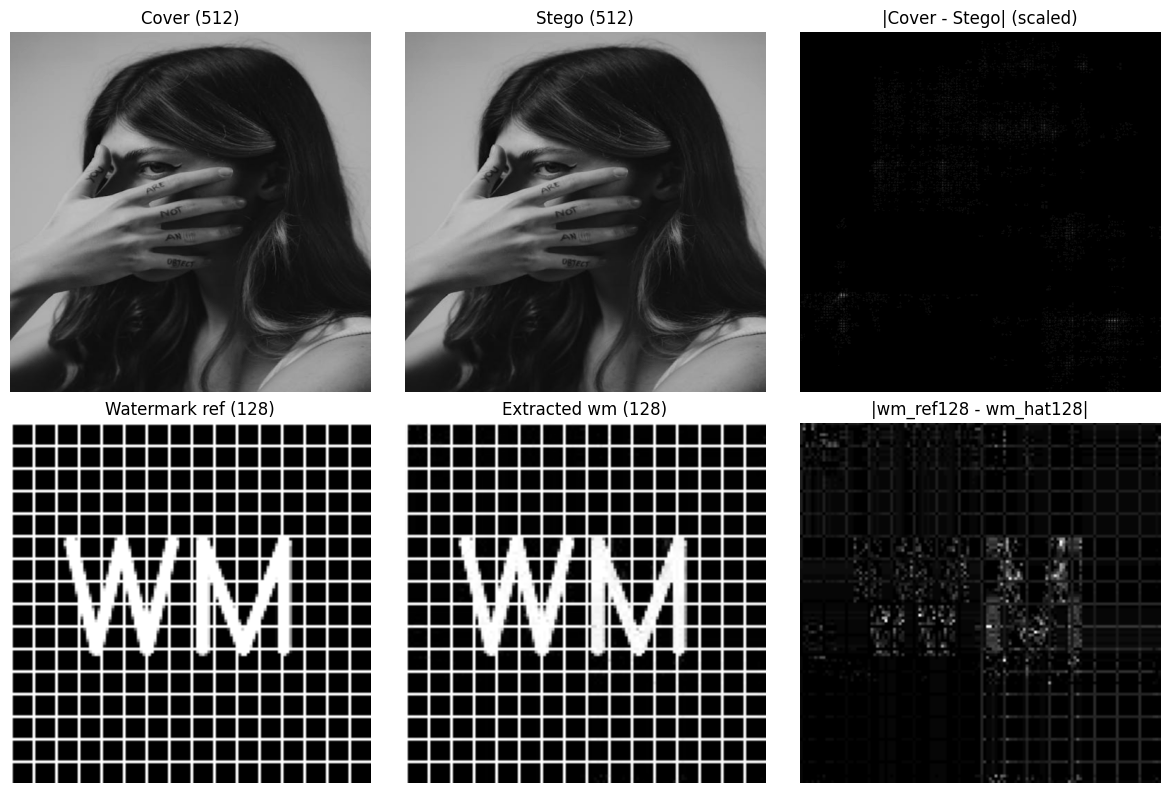

Saved evidence images to: D:\sina_intern\jupyterProject\467\samples\_previews
Panel: D:\sina_intern\jupyterProject\467\samples\_previews\evidence_panel_v4.png


In [91]:
# Assumes you already have these variables from your v4 run:
# cover (512x512 uint8), stego_preview (512x512 uint8)
# wm (256x256 uint8), wm_hat_128 (128x128 uint8), wm_hat_256 (256x256 uint8)
# Also assumes cv2 and Path are already available in your notebook as before.

import matplotlib.pyplot as plt

out_dir = Path("samples") / "_previews"
out_dir.mkdir(parents=True, exist_ok=True)

# Build baseline upsample for fair 256-level comparison
wm_128 = cv2.resize(wm, (128, 128), interpolation=cv2.INTER_NEAREST)
wm_256_baseline = cv2.resize(wm_128, (256, 256), interpolation=cv2.INTER_NEAREST)

def save_gray(path, img_u8):
    cv2.imwrite(str(path), img_u8)

def diff_u8(a_u8, b_u8):
    return np.abs(a_u8.astype(np.int16) - b_u8.astype(np.int16)).astype(np.uint8)

# 1) Save the three evidence images directly (as you asked)
save_gray(out_dir / "evidence_cover_512.png", cover)
save_gray(out_dir / "evidence_stego_512.png", stego_preview)
save_gray(out_dir / "evidence_wm_hat_128.png", wm_hat_128)
save_gray(out_dir / "evidence_wm_hat_256.png", wm_hat_256)

# 2) Save diff maps (scaled for visibility)
diff_cover = diff_u8(cover, stego_preview)
diff_wm128 = diff_u8(wm_128, wm_hat_128)
diff_wm256 = diff_u8(wm, wm_hat_256)

save_gray(out_dir / "evidence_diff_cover_stego.png", diff_cover)
save_gray(out_dir / "evidence_diff_wm128.png", diff_wm128)
save_gray(out_dir / "evidence_diff_wm256.png", diff_wm256)

# 3) Create a single summary panel figure
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(2, 3, 1)
ax.imshow(cover, cmap="gray", vmin=0, vmax=255)
ax.set_title("Cover (512)")
ax.axis("off")

ax = fig.add_subplot(2, 3, 2)
ax.imshow(stego_preview, cmap="gray", vmin=0, vmax=255)
ax.set_title("Stego (512)")
ax.axis("off")

ax = fig.add_subplot(2, 3, 3)
ax.imshow(diff_cover, cmap="gray")
ax.set_title("|Cover - Stego| (scaled)")
ax.axis("off")

ax = fig.add_subplot(2, 3, 4)
ax.imshow(wm_128, cmap="gray", vmin=0, vmax=255)
ax.set_title("Watermark ref (128)")
ax.axis("off")

ax = fig.add_subplot(2, 3, 5)
ax.imshow(wm_hat_128, cmap="gray", vmin=0, vmax=255)
ax.set_title("Extracted wm (128)")
ax.axis("off")

ax = fig.add_subplot(2, 3, 6)
ax.imshow(diff_wm128, cmap="gray")
ax.set_title("|wm_ref128 - wm_hat128|")
ax.axis("off")

fig.tight_layout()
panel_path = out_dir / "evidence_panel_v4.png"
fig.savefig(panel_path, dpi=200)
plt.show()

print("Saved evidence images to:", out_dir.resolve())
print("Panel:", panel_path.resolve())


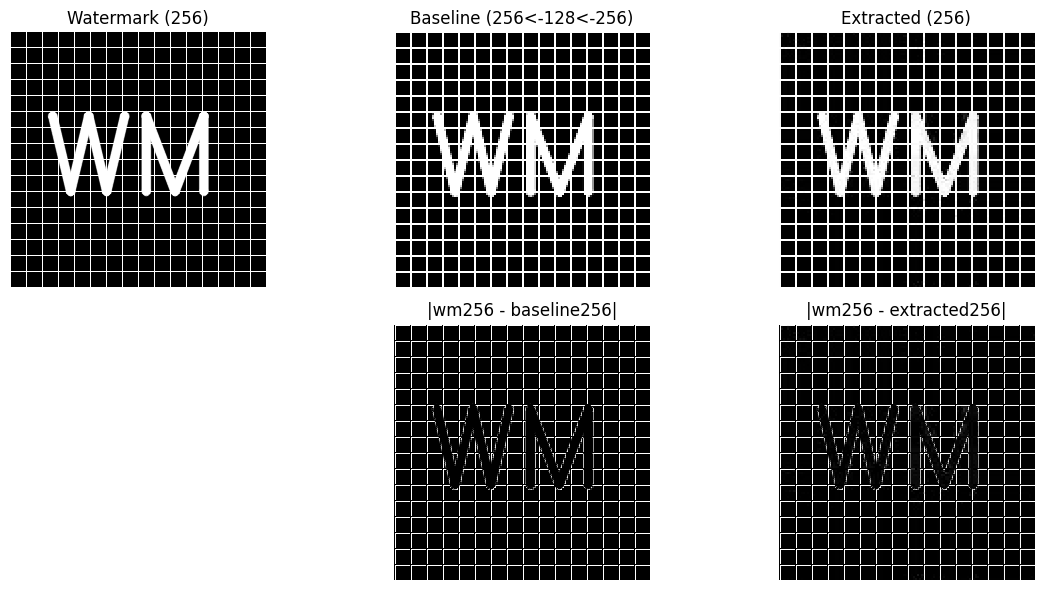

Saved: D:\sina_intern\jupyterProject\467\samples\_previews\evidence_panel_wm256_upperbound.png
Also wrote baseline/diff images into: D:\sina_intern\jupyterProject\467\samples\_previews


In [93]:
#wm256 vs baseline(256<-128<-256) vs extracted256

import matplotlib.pyplot as plt

out_dir = Path("samples") / "_previews"
out_dir.mkdir(parents=True, exist_ok=True)

# Build baseline upsample for the 0.74 upper-bound argument
wm_128 = cv2.resize(wm, (128, 128), interpolation=cv2.INTER_NEAREST)
wm_256_baseline = cv2.resize(wm_128, (256, 256), interpolation=cv2.INTER_NEAREST)

def diff_u8(a_u8, b_u8):
    return np.abs(a_u8.astype(np.int16) - b_u8.astype(np.int16)).astype(np.uint8)

diff_base = diff_u8(wm, wm_256_baseline)
diff_ext  = diff_u8(wm, wm_hat_256)

fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(2, 3, 1)
ax.imshow(wm, cmap="gray", vmin=0, vmax=255)
ax.set_title("Watermark (256)")
ax.axis("off")

ax = fig.add_subplot(2, 3, 2)
ax.imshow(wm_256_baseline, cmap="gray", vmin=0, vmax=255)
ax.set_title("Baseline (256<-128<-256)")
ax.axis("off")

ax = fig.add_subplot(2, 3, 3)
ax.imshow(wm_hat_256, cmap="gray", vmin=0, vmax=255)
ax.set_title("Extracted (256)")
ax.axis("off")

ax = fig.add_subplot(2, 3, 5)
ax.imshow(diff_base, cmap="gray")
ax.set_title("|wm256 - baseline256|")
ax.axis("off")

ax = fig.add_subplot(2, 3, 6)
ax.imshow(diff_ext, cmap="gray")
ax.set_title("|wm256 - extracted256|")
ax.axis("off")

fig.tight_layout()
panel_path = out_dir / "evidence_panel_wm256_upperbound.png"
fig.savefig(panel_path, dpi=200)
plt.show()

cv2.imwrite(str(out_dir / "evidence_wm256_baseline.png"), wm_256_baseline)
cv2.imwrite(str(out_dir / "evidence_diff_wm256_baseline.png"), diff_base)
cv2.imwrite(str(out_dir / "evidence_diff_wm256_extracted.png"), diff_ext)

print("Saved:", panel_path.resolve())
print("Also wrote baseline/diff images into:", out_dir.resolve())

In [96]:
out_dir = Path("samples") / "_previews"
out_dir.mkdir(parents=True, exist_ok=True)

# Evidence images requested
cv2.imwrite(str(out_dir / "evidence_cover_512.png"), cover)
cv2.imwrite(str(out_dir / "evidence_stego_512.png"), stego_preview)
cv2.imwrite(str(out_dir / "evidence_wm_hat_128.png"), wm_hat_128)
cv2.imwrite(str(out_dir / "evidence_wm_hat_256.png"), wm_hat_256)

# Baseline upsample (256 <- 128 <- 256) for the upper-bound argument
wm_128 = cv2.resize(wm, (128, 128), interpolation=cv2.INTER_NEAREST)
wm_256_baseline = cv2.resize(wm_128, (256, 256), interpolation=cv2.INTER_NEAREST)
cv2.imwrite(str(out_dir / "evidence_wm256_baseline.png"), wm_256_baseline)

print("Saved evidence to:", out_dir.resolve())
print("Files:",
      "evidence_cover_512.png, evidence_stego_512.png, evidence_wm_hat_128.png, evidence_wm_hat_256.png, evidence_wm256_baseline.png")


Saved evidence to: D:\sina_intern\jupyterProject\467\samples\_previews
Files: evidence_cover_512.png, evidence_stego_512.png, evidence_wm_hat_128.png, evidence_wm_hat_256.png, evidence_wm256_baseline.png
